In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Iniciando el proceso de Ingeniería de Características...
DataFrame con características numéricas creado:
   eventID  n_hits  radius_mean  radius_std      beta
0        0       7    68.986952   12.220050  0.985278
1        1      15    92.402359   11.774479  0.993355
2        2      14    85.533433   23.736042  0.995086
3        3      15    99.055209    9.205426  0.996539
4        4      15    93.541702   15.218940  0.995639

Total de eventos procesados: 99375

Datos listos para entrenar. Forma de X_train: (79500, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 192 (768.00 B)


Iniciando entrenamiento del modelo con características numéricas...
Epoch 1/200
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2033 - r2_score: -6472.8716 - val_loss: 0.0732 - val_r2_score: -2318.6863
Epoch 2/200
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1058 - r2_score: -3385.7271 - val_loss: 0.0252 - val_r2_score: -803.9630
Epoch 3/200
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0558 - r2_score: -1781.6495 - val_loss: 0.0073 - val_r2_score: -233.5554
Epoch 4/200
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0294 - r2_score: -942.0119 - val_loss: 0.0029 - val_r2_score: -90.4910
Epoch 5/200
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0179 - r2_score: -563.7359 - val_loss: 0.0030 - val_r2_score: -90.7510
Epoch 6/200
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0126 - r2_score: -396.2396 - val_loss: 0.0034 - val_r2_score: -103.4544
Epoch 7/200
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0100 - r2_score: -319.7348 - val_loss: 0.0032 - val_r2_s

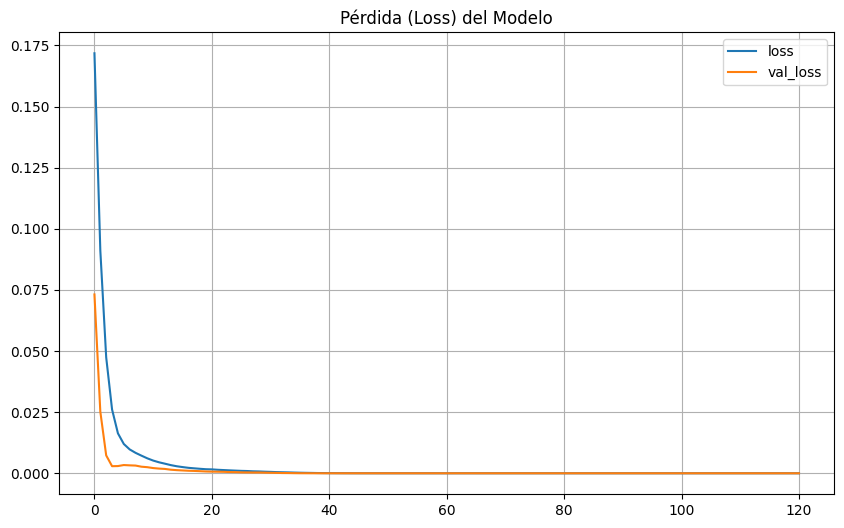

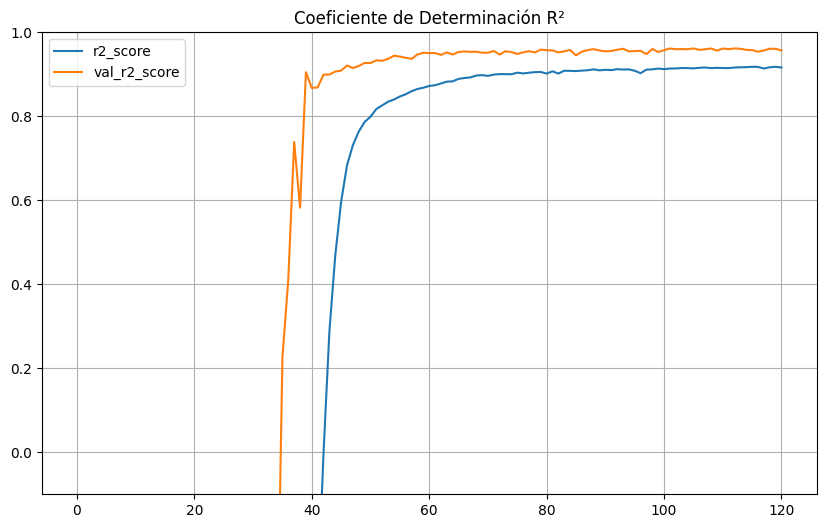

In [2]:
import os, shutil, math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                     Flatten, Dense, BatchNormalization,
                                     Activation, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from scipy.stats import gaussian_kde

#Función para calcular beta teórica
M = 938.272           # MeV/c²

def beta(E, m=M):
    γ = 1.0 + E/m
    return math.sqrt(1.0 - 1.0/γ**2)

def cuantizar_hits(x, y, paso=8.5, x0=0.0, y0=0.0, modo="centro"):

    i = np.floor((x - x0) / paso).astype(int)
    j = np.floor((y - y0) / paso).astype(int)

    if modo == "centro":
        xq = x0 + (i + 0.5) * paso
        yq = y0 + (j + 0.5) * paso
    elif modo == "floor":
        xq = x0 + i * paso
        yq = y0 + j * paso
    else:
        raise ValueError("modo debe ser 'centro' o 'floor'")

    return xq, yq

RUTA_CSV     = "/content/drive/MyDrive/datos hits/Prueba.csv"

df_uno = pd.read_csv(RUTA_CSV)

# Convierte a numérico las columnas relevantes (por si hay strings u otros problemas)
cols_to_center = ["x(mm)", "y(mm)"]

# Asegura que son numéricas
df_uno[cols_to_center] = df_uno[cols_to_center].apply(pd.to_numeric, errors='coerce')

# Calcula el centroide (media) por evento
df_uno[["x0(mm)", "y0(mm)"]] = df_uno.groupby("eventID")[cols_to_center].transform("mean")

# Centrar por evento
df_centered = df_uno.copy()
df_centered[cols_to_center] = df_centered[cols_to_center] - df_centered[["x0(mm)", "y0(mm)"]].to_numpy()

df_centered["x(mm)"], df_centered["y(mm)"] = cuantizar_hits(df_centered["x(mm)"].values, df_centered["y(mm)"].values, paso=8.5, x0=0.0, y0=0.0, modo="centro")


# Eliminar puntos dentro de un radio mínimo
radio_minimo = 10  # mm
distancia = np.sqrt(df_centered["x(mm)"]**2 + df_centered["y(mm)"]**2)
df_filtrado = df_centered[distancia >= radio_minimo].copy()

df_filtrado.reset_index(drop=True, inplace=True)

print("Iniciando el proceso de Ingeniería de Características...")

# Extracción de Características

# Calcula la distancia de cada punto al centro (0,0)
df_filtrado['radius'] = np.sqrt(df_filtrado['x(mm)']**2 + df_filtrado['y(mm)']**2)

# Agrupa por evento y calcula las características agregadas
features_list = []
energy_col = next(c for c in df_filtrado.columns if "energy" in c.lower())

for event_id, grp in df_filtrado.groupby('eventID'):
    # Características extraídas del anillo
    n_hits = len(grp)
    radius_mean = grp['radius'].mean()
    radius_std = grp['radius'].std()

    # Obtener la energía y calcular beta (nuestra etiqueta)
    energy = grp[energy_col].iloc[0]
    beta_val = beta(energy)

    features_list.append({
        'eventID': event_id,
        'n_hits': n_hits,
        'radius_mean': radius_mean,
        'radius_std': radius_std,
        'beta': beta_val
    })

# Crea un nuevo DataFrame con una fila por evento
df_features = pd.DataFrame(features_list).fillna(0) # .fillna(0) por si std es NaN (eventos con 1 solo hit)

print("DataFrame con características numéricas creado:")
print(df_features.head())
print(f"\nTotal de eventos procesados: {len(df_features)}")

# Preparación de los Datos

# Separa las características (X) y la etiqueta (y)
features = ['n_hits', 'radius_mean', 'radius_std']
target = 'beta'

X = df_features[features]
y = df_features[target]

# Divide en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Escala las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nDatos listos para entrenar. Forma de X_train: {X_train_scaled.shape}")

#Creación del Modelo (Red Neuronal Densa / MLP)

# Métrica R² personalizada
def r2_score(y_true, y_pred):
    ss_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
    ss_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Definición del modelo
inp = tf.keras.Input(shape=(len(features),)) # La entrada es un vector de 3 características
x = tf.keras.layers.Dense(64, activation='relu')(inp)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

# Capa de salida acotada (reutilizamos la idea que funcionaba)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
out = tf.keras.layers.Lambda(lambda v: v * 1.2)(x)

model = tf.keras.Model(inp, out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[r2_score]
)

model.summary()

# Entrenamiento y Evaluación

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# Graficar resultados
print("\nEntrenamiento finalizado. Mostrando gráficas de rendimiento...")
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title('Pérdida (Loss) del Modelo')
plt.grid(True)
plt.show()

pd.DataFrame(history.history)[['r2_score', 'val_r2_score']].plot(figsize=(10, 6))
plt.title('Coeficiente de Determinación R²')
plt.ylim(-0.1, 1) # Ajusta el eje Y para ver mejor si R² se vuelve positivo
plt.grid(True)

Esta celda contiene la mayor parte del código para entrenar un modelo de red neuronal (un Perceptrón Multicapa o MLP) para predecir la velocidad beta ($\beta$) de una partícula. El proceso se divide en las siguientes fases:

#### 1. **Configuración Inicial**
- **Importaciones**: Se importan todas las librerías necesarias:
    - `numpy` y `pandas` para manipulación de datos.
    - `matplotlib` para visualización.
    - `sklearn` para dividir los datos y escalarlos.
    - `tensorflow.keras` para construir y entrenar la red neuronal.
- **Funciones Auxiliares**:
    - `beta(E)`: Calcula la velocidad teórica ($\beta$) de una partícula a partir de su energía cinética `E`. Este valor se usará como la "verdad" (etiqueta) para entrenar el modelo.
    - `cuantizar_hits(x, y)`: Agrupa las coordenadas `(x, y)` en una grilla discreta, similar a píxeles.

#### 2. **Preprocesamiento de Datos**
- **Carga**: Se lee un archivo CSV (`Prueba.csv`) que contiene los datos de los *hits*.
- **Centrado**: Para cada "evento" (un conjunto de *hits* de una misma partícula), se calcula el centroide (la posición promedio) y se restan esas coordenadas a todos los *hits* del evento. Esto centra cada anillo de Cherenkov en el origen `(0,0)`, eliminando la variación por la posición.
- **Cuantización**: Se aplica la función `cuantizar_hits` para ajustar las posiciones a una grilla.
- **Filtrado Radial**: Se eliminan los *hits* que están muy cerca del centro (dentro de un `radio_minimo` de 20 mm). Esto ayuda a limpiar el ruido que puede haber en el centro del detector.

#### 3. **Ingeniería de Características (Feature Engineering)**
En lugar de usar las imágenes de los *hits*, este modelo usa características numéricas extraídas de ellos:
- Se calcula la distancia (`radius`) de cada *hit* al centro `(0,0)`.
- Para cada evento, se agrupan los *hits* y se calculan tres características:
    1.  **`n_hits`**: El número total de *hits*.
    2.  **`radius_mean`**: El radio promedio de los *hits*.
    3.  **`radius_std`**: La desviación estándar de los radios, que indica qué tan disperso o bien definido está el anillo.
- Estas características, junto con la $\beta$ teórica, se guardan en un nuevo DataFrame `df_features`.

#### 4. **Preparación para el Entrenamiento**
- **División de Datos**: Las características (`n_hits`, `radius_mean`, `radius_std`) se definen como `X` (entrada del modelo), y la `beta` teórica se define como `y` (salida deseada). El conjunto de datos se divide en un 80% para entrenamiento (`X_train`, `y_train`) y un 20% para validación (`X_val`, `y_val`).
- **Escalado**: Se utiliza `StandardScaler` de `sklearn` para estandarizar las características de entrada `X`. Esto asegura que todas las características tengan una media de 0 y una desviación estándar de 1, lo cual es crucial para que las redes neuronales aprendan eficientemente.

#### 5. **Construcción del Modelo (MLP)**
- **Métrica**: Se define una función `r2_score` para calcular el coeficiente de determinación (R²), que mide qué tan bien las predicciones del modelo se ajustan a los datos reales.
- **Arquitectura**: Se construye una red neuronal secuencial simple:
    - **Capa de Entrada**: Acepta un vector con las 3 características de entrada.
    - **Capas Ocultas**: Dos capas densas (`Dense`) con activación `relu`, intercaladas con `BatchNormalization` (para estabilizar el entrenamiento) y `Dropout` (para prevenir el sobreajuste).
    - **Capa de Salida**: Una capa `Dense` con una sola neurona y activación `sigmoid`, que produce una salida entre 0 y 1. Se añade una capa `Lambda` para re-escalar esta salida a un rango de `0` a `1.2`, lo que puede ser más adecuado para los valores de $\beta$.
- **Compilación**: El modelo se compila con el optimizador `Adam`, la función de pérdida de error cuadrático medio (`mse`), y se monitorea con la métrica `r2_score`.

#### 6. **Entrenamiento y Evaluación**
- **Entrenamiento**: El modelo se entrena usando el método `model.fit` con los datos de entrenamiento escalados.
    - Se usa un *callback* de `EarlyStopping` que detiene el entrenamiento si la pérdida en los datos de validación no mejora durante 15 épocas, restaurando los mejores pesos encontrados para evitar el sobreajuste.
- **Visualización**: Al finalizar el entrenamiento, se generan dos gráficos:
    1.  **Pérdida (Loss)**: Muestra cómo el error del modelo (`loss` y `val_loss`) disminuye a lo largo de las épocas.
    2.  **Coeficiente de Determinación (R²)**: Muestra cómo la métrica R² (`r2_score` y `val_r2_score`) mejora con el entrenamiento, acercándose idealmente a 1.

In [3]:
 import pickle
 model.save("betanet_v5.h5")
 with open('data_scaler.pkl', 'wb') as f:
     pickle.dump(scaler, f)

Esta celda guarda los resultados del entrenamiento para poder usarlos en el futuro sin necesidad de volver a entrenar.

1.  **`model.save("betanet_v5.h5")`**: Guarda la arquitectura completa del modelo, sus pesos aprendidos y la configuración del optimizador en un único archivo en formato HDF5 (`.h5`). Este archivo puede ser cargado más tarde para hacer predicciones.

2.  **`pickle.dump(scaler, f)`**: Guarda el objeto `scaler` (el `StandardScaler` que fue ajustado con los datos de entrenamiento) en un archivo llamado `data_scaler.pkl`. Esto es fundamental, ya que para hacer predicciones correctas sobre datos nuevos, estos deben ser escalados *exactamente* de la misma manera que los datos de entrenamiento.

## Predicción 5 eventos nuevos

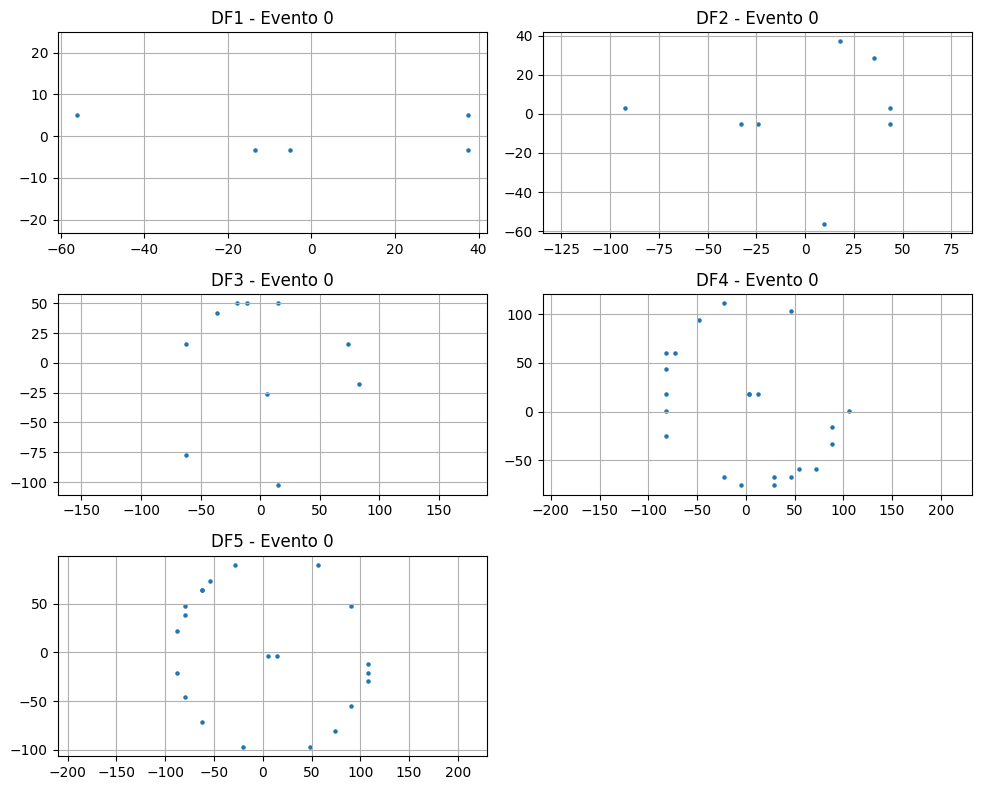

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Rutas
RUTA_CSV1 = "/content/drive/MyDrive/datos hits/P3_5GEV.csv"
RUTA_CSV2 = "/content/drive/MyDrive/datos hits/P4GEV.csv"
RUTA_CSV3 = "/content/drive/MyDrive/datos hits/P5GEV.csv"
RUTA_CSV4 = "/content/drive/MyDrive/datos hits/P7GEV.csv"
RUTA_CSV5 = "/content/drive/MyDrive/datos hits/P10GEV.csv"

# Cargar primeros 500 hits de cada archivo
df1 = pd.read_csv(RUTA_CSV1).head(50000)
df2 = pd.read_csv(RUTA_CSV2).head(50000)
df3 = pd.read_csv(RUTA_CSV3).head(50000)
df4 = pd.read_csv(RUTA_CSV4).head(50000)
df5 = pd.read_csv(RUTA_CSV5).head(50000)

dataframes = [df1, df2, df3, df4, df5]

for df in dataframes:
    df["x(mm)"], df["y(mm)"] = cuantizar_hits(
        df["x(mm)"].to_numpy(),
        df["y(mm)"].to_numpy(),
        paso=8.5, x0=0.0, y0=0.0, modo="centro"
    )

cols_to_center = ["x(mm)", "y(mm)"]

# Asegurar que las columnas son numéricas y centrar por evento
df_centered_list = []
for df in dataframes:
    # Asegurar numérico
    for col in cols_to_center:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df_centered = df.copy()

    # Guardar los centroides (medias por evento) -> devuelve dos columnas
    df_centered[["x0(mm)", "y0(mm)"]] = df_centered.groupby("eventID")[cols_to_center].transform("mean")

    # Centrar usando esas medias
    df_centered[cols_to_center] = df_centered[cols_to_center] - df_centered[["x0(mm)", "y0(mm)"]].to_numpy() #Centra los datos restando a cada punto el punto central real

    df_centered_list.append(df_centered)

# Graficar un evento por DataFrame
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
axes = axes.flatten()
titles = ['DF1', 'DF2', 'DF3', 'DF4', 'DF5']

for i, df_centered in enumerate(df_centered_list):
    ax = axes[i]
    # Elegir el primer evento del DataFrame
    first_event = df_centered['eventID'].unique()[0]
    df_event = df_centered[df_centered['eventID'] == first_event]
    ax.scatter(df_event["x(mm)"], df_event["y(mm)"], s=5)
    ax.set_title(f"{titles[i]} - Evento {first_event}")
    ax.axis('equal')
    ax.grid(True)

# Si hay más subplots que DataFrames, ocultar el sobrante
for j in range(len(df_centered_list), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Esta celda se encarga de cargar y preprocesar cinco conjuntos de datos diferentes, cada uno correspondiente a una energía de partícula distinta (3.5, 4, 5, 7 y 10 GeV), para luego visualizar un ejemplo de cada uno.

#### 1. **Carga de Datos**
- Se definen las rutas a cinco archivos CSV diferentes, cada uno etiquetado con la energía de la partícula.
- Se lee cada archivo usando `pandas` y se toman las primeras 50,000 filas (`.head(50000)`) para trabajar con un subconjunto manejable.
- Los DataFrames resultantes se almacenan en una lista llamada `dataframes`.

#### 2. **Cuantización y Centrado**
- El código itera sobre cada DataFrame en la lista.
- **Cuantización**: Se aplica la función `cuantizar_hits` para ajustar las coordenadas `(x, y)` de los impactos a una grilla uniforme.
- **Centrado por Evento**: Para cada DataFrame, se realiza el proceso de centrado:
    - Se calcula el centroide (posición promedio) para cada evento.
    - Se restan las coordenadas del centroide a todos los *hits* del evento correspondiente.
- El resultado es una lista `df_centered_list`, que contiene los cinco DataFrames preprocesados y listos para el análisis.

#### 3. **Visualización de Ejemplos**
- Se crea una figura con una cuadrícula de 3x2 subplots.
- Se itera sobre la lista `df_centered_list`. Para cada DataFrame:
    - Se selecciona el **primer evento** único que aparece en él.
    - Se crea un gráfico de dispersión (`scatter plot`) mostrando las coordenadas `(x, y)` de los *hits* de ese evento.
    - Se ajusta el título del gráfico y se asegura que los ejes tengan la misma escala (`axis('equal')`) para una visualización correcta del anillo.
- El último subplot, que queda vacío, se oculta. Finalmente, `plt.show()` muestra los cinco anillos de Cherenkov de ejemplo.

Este código procesa y grafica los impactos de fotones Cherenkov contenidos en cinco archivos `.csv` correspondientes a energías diferentes (3.5, 4, 5, 7 y 10 GeV).

#### 1. Carga de datos
Se leen los archivos CSV que contienen las posiciones de los hits para cada energía:

- `3.5 GeV`
- `4 GeV`
- `5 GeV`
- `7 GeV`
- `10 GeV`

Cada archivo contiene múltiples eventos con las coordenadas de impacto de los fotones en el plano detector.

---

#### 2. Cuantización de hits
Cada impacto se ajusta a una **malla discreta** de tamaño fijo (`paso=8.5 mm`).  
Esto permite representar las posiciones como píxeles en una imagen y homogenizar el análisis de todos los eventos.

---

#### 3. Centrando por evento
Para cada evento se calcula el **centroide (x₀, y₀)** y luego se restan esas coordenadas a cada hit, de modo que todos los anillos queden alineados en torno al origen.

Esto elimina variaciones de traslación y facilita la comparación entre diferentes energías.

---

#### 4. Selección y graficado
De cada archivo se toma el **primer evento** y se grafican sus hits en un diagrama de dispersión en coordenadas XY.  
Cada subplot corresponde a una energía distinta.

---

#### 5. Visualización final
Los diagramas se organizan en una cuadrícula de **3×2 subplots**.  
Si sobran espacios, se ocultan. Se muestran los impactos de cada energía centrados y listos para análisis comparativo.

In [5]:
import numpy as np

radio_minimo = 10  # mm

df_filtrados = []  # Aquí guardaremos los DataFrames filtrados

for df_centered in df_centered_list:
    # Calcular la distancia euclidiana desde el centro (0,0)
    distancia = np.sqrt(df_centered["x(mm)"]**2 + df_centered["y(mm)"]**2)

    # Filtrar solo los hits con distancia >= radio_minimo
    df_filtrado = df_centered[distancia >= radio_minimo].copy()

    df_filtrados.append(df_filtrado)

Esta celda realiza un filtrado radial sobre los datos previamente centrados.

- Se define un `radio_minimo` de 10 mm.
- Se itera a través de cada DataFrame en la lista `df_centered_list`.
- Para cada DataFrame, se calcula la distancia euclidiana de cada *hit* desde el origen `(0,0)`.
- Se crea un nuevo DataFrame `df_filtrado` que contiene únicamente los *hits* cuya distancia es **mayor o igual** al `radio_minimo`.
- Los DataFrames ya filtrados se guardan en una nueva lista llamada `df_filtrados`.

El propósito de este paso es eliminar el ruido o los *hits* irrelevantes que puedan encontrarse muy cerca del centro, conservando solo los que forman el anillo de Cherenkov.

## Gráfica de un ejemplo por dataset de los datos filtrados


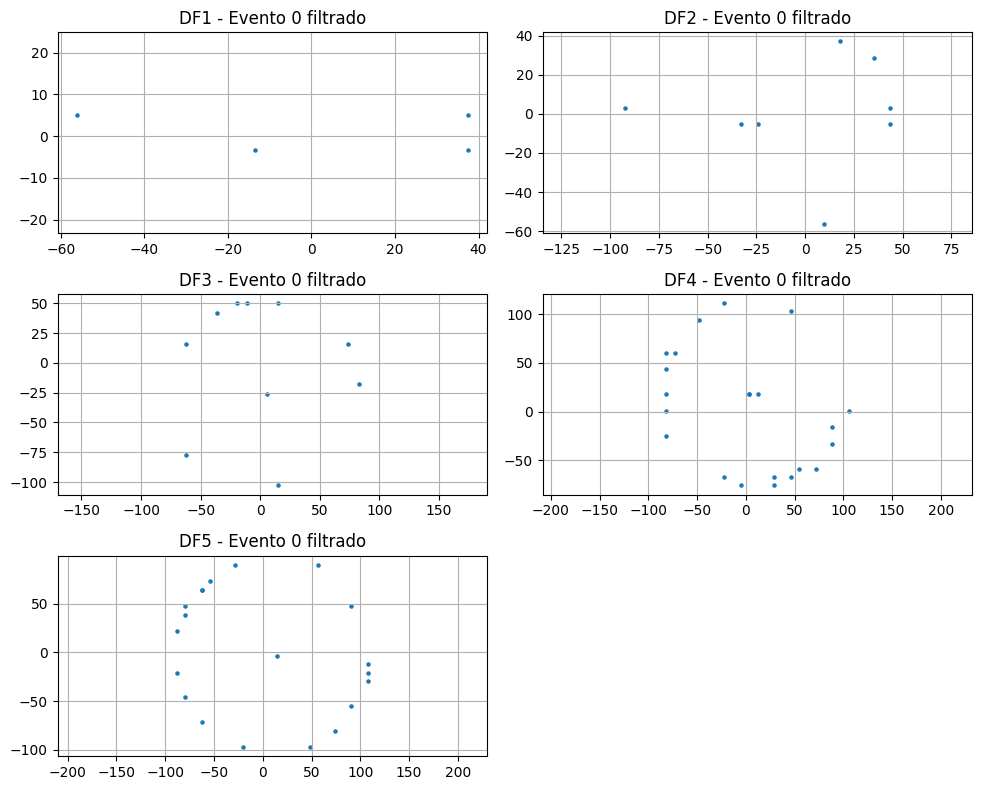

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
axes = axes.flatten()
titles = ['DF1', 'DF2', 'DF3', 'DF4', 'DF5']

for i, df_filtrado in enumerate(df_filtrados):
    ax = axes[i]
    first_event = df_filtrado['eventID'].unique()[0]
    df_event = df_filtrado[df_filtrado['eventID'] == first_event]
    ax.scatter(df_event["x(mm)"], df_event["y(mm)"], s=5)
    ax.set_title(f"{titles[i]} - Evento {first_event} filtrado")
    ax.axis('equal')
    ax.grid(True)

for j in range(len(df_filtrados), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

df_filtrados = df_centered_list

Esta celda visualiza los datos **después** de haber aplicado el filtro radial de la celda anterior.

- Al igual que antes, crea una cuadrícula de subplots y muestra el primer evento de cada uno de los cinco DataFrames.
- La diferencia es que ahora utiliza la lista `df_filtrados`, que contiene los datos sin los *hits* centrales.
- Al final, la línea `df_filtrados = df_centered_list` reasigna la variable. Esto significa que las celdas posteriores volverán a trabajar con los datos centrados pero **no filtrados** (es decir, con los hits centrales incluidos).

Cargando el modelo y el escalador guardados...
❌ Error: Asegúrate de que los archivos 'beta_predictor_model.h5' y 'data_scaler.pkl' están en la misma carpeta.

===== Procesando y prediciendo para DataFrame #1 =====
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ Predicciones guardadas para el DataFrame #1.

===== Procesando y prediciendo para DataFrame #2 =====
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ Predicciones guardadas para el DataFrame #2.

===== Procesando y prediciendo para DataFrame #3 =====
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ Predicciones guardadas para el DataFrame #3.

===== Procesando y prediciendo para DataFrame #4 =====
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Predicciones guardadas para el DataFrame #4.

===== Procesando y prediciendo para DataFrame #5 =====
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Predicciones guardadas para el DataFrame #5.


🎉 Todas las predicciones han sido generadas y guardadas.


📊 ===== Análisis para Energía = 3500 MeV =====
Media de β_pred s

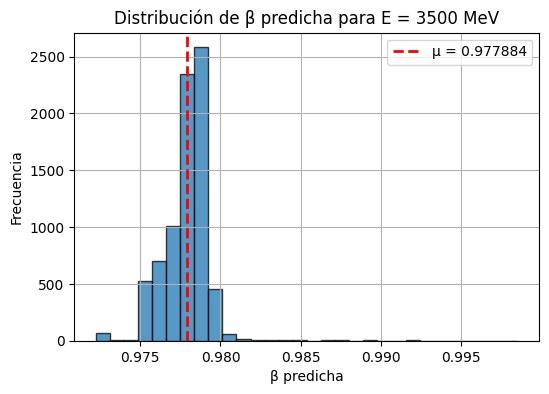

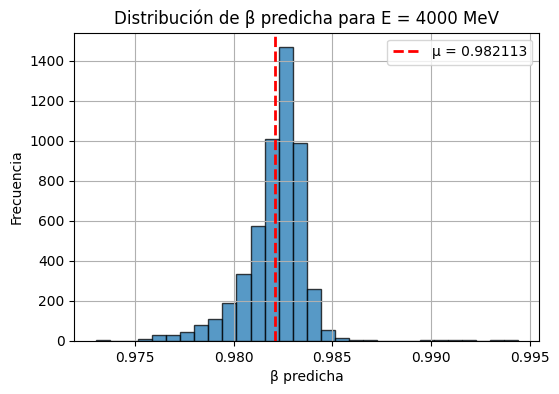

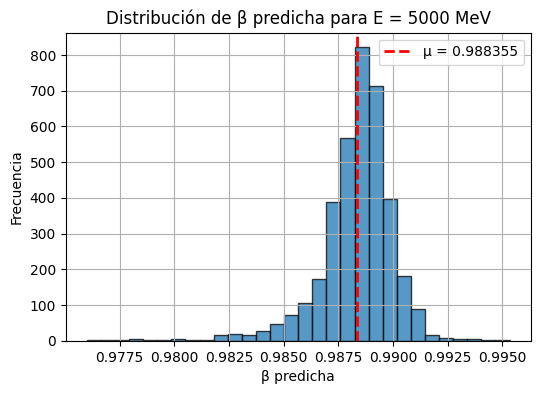

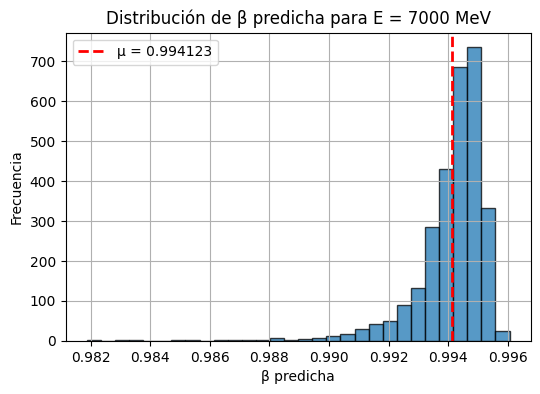

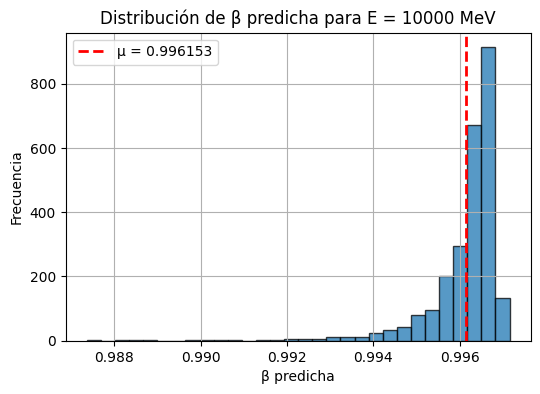

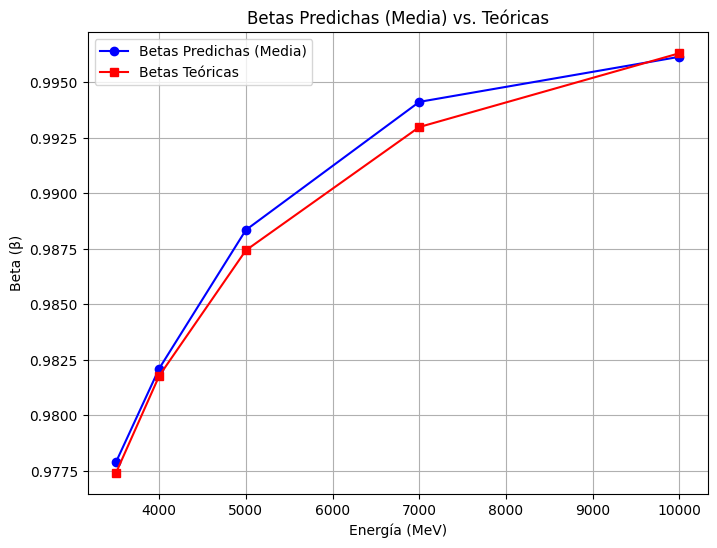

Pendiente de las betas predichas (m): 0.9950874387069475
Pendiente de las betas teóricas (m): 1.0000000000000127
Diferencia de pendientes: 0.004912561293065165


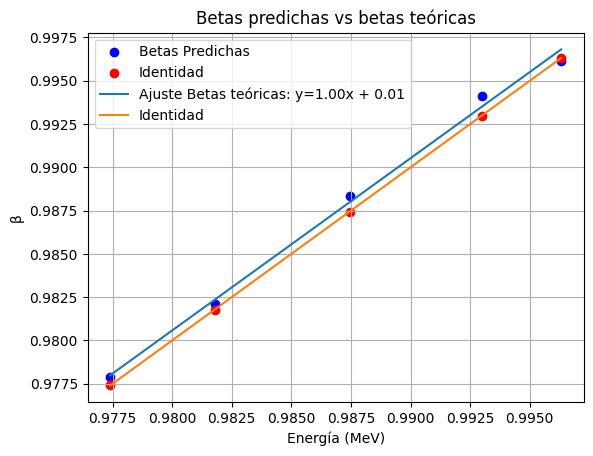

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import math

# Carga el Modelo y el Escalador
try:

    model = tf.keras.models.load_model(
        "betanet.h5",
        custom_objects={'r2_score': r2_score},
        safe_mode=False
    )

    with open('data_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    print("✅ Modelo y escalador cargados correctamente.")

except FileNotFoundError:
    print("❌ Error: Asegúrate de que los archivos 'beta_predictor_model.h5' y 'data_scaler.pkl' están en la misma carpeta.")
    exit()

# Lista vacía para guardar los arrays de predicciones de cada DataFrame
all_predictions = []

# Bucle para procesar cada DataFrame y guardar sus predicciones
for i, df_individual_centered in enumerate(df_centered_list):
    print(f"\n===== Procesando y prediciendo para DataFrame #{i+1} =====")

    # Extrae Características
    df_individual_centered['radius'] = np.sqrt(df_individual_centered['x(mm)']**2 + df_individual_centered['y(mm)']**2)
    features_list = []
    for event_id, grp in df_individual_centered.groupby('eventID'):
        features_list.append({
            'eventID': event_id,
            'n_hits': len(grp),
            'radius_mean': grp['radius'].mean(),
            'radius_std': grp['radius'].std()
        })
    df_features = pd.DataFrame(features_list).fillna(0)

    if df_features.empty:
        print("No se encontraron eventos. Saltando al siguiente DataFrame.")
        # Añadimos un array vacío para mantener la correspondencia con la lista de Energías
        all_predictions.append(np.array([]))
        continue

    # Escalar Características
    features_cols = ['n_hits', 'radius_mean', 'radius_std']
    X_new = df_features[features_cols]
    X_new_scaled = scaler.transform(X_new)

    # Realizar Predicciones
    predicted_betas = model.predict(X_new_scaled)

    # Guardar las predicciones en nuestra lista
    # .flatten() convierte el array de (n, 1) a (n,) para que sea más fácil de manejar
    all_predictions.append(predicted_betas.flatten())
    print(f"✅ Predicciones guardadas para el DataFrame #{i+1}.")

print("\n\n🎉 Todas las predicciones han sido generadas y guardadas.")

# ANÁLISIS Y GRAFICACIÓN

# Lista de energías correspondientes a cada uno los DataFrames
E = [3500, 4000, 5000, 7000, 10000]

# Ahora, iteramos sobre la lista de predicciones que acabamos de crear
for k, beta_preds in enumerate(all_predictions):

    # Si no hubo predicciones para este DataFrame, lo saltamos
    if len(beta_preds) == 0:
        continue

    print(f"\n\n📊 ===== Análisis para Energía = {E[k]} MeV =====")

    beta_mean = beta_preds.mean()
    print(f"Media de β_pred sobre {len(beta_preds)} eventos: {beta_mean:.6f}")

    # Grafica la distribución (histograma de barras) y marca la media
    plt.figure(figsize=(6,4))
    n, bins, patches = plt.hist(beta_preds, bins=30, edgecolor='k', alpha=0.75)
    plt.axvline(beta_mean, color='red', linestyle='--', linewidth=2, label=f'μ = {beta_mean:.6f}')
    plt.xlabel('β predicha')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de β predicha para E = {E[k]} MeV')
    plt.legend()
    plt.grid(True)



# Lista de energías correspondientes a los DataFrames
E = [3500, 4000, 5000, 7000, 10000]

# Almacenar las medias de las predicciones
mean_predicted_betas = []
betas_teo_list = []

print("\n\n📊 ===== Iniciando Análisis Individual por Energía =====")
# Iteramos sobre la lista de predicciones que creamos antes
for k, beta_preds in enumerate(all_predictions):
    if len(beta_preds) == 0:
        continue

    print(f"\n--- Análisis para Energía = {E[k]} MeV ---")

    beta_mean = beta_preds.mean()
    print(f"Media de β_pred: {beta_mean:.6f}")

    # Calculamos la beta teórica
    beta_teo = beta(E[k])

    # Guarda la media de la predicción y el valor teórico las listas
    mean_predicted_betas.append(beta_mean)
    betas_teo_list.append(beta_teo)

# Graficar las medias vs. las teóricas

plt.figure(figsize=(8, 6))

# Graficar las medias de las predicciones
plt.plot(E, mean_predicted_betas, marker='o', linestyle='-', color='blue', label='Betas Predichas (Media)')

# Graficar los valores teóricos
plt.plot(E, betas_teo_list, marker='s', linestyle='-', color='red', label='Betas Teóricas')

# Añadir título y etiquetas
plt.title('Betas Predichas (Media) vs. Teóricas')
plt.xlabel('Energía (MeV)')
plt.ylabel('Beta (β)')
plt.legend()
plt.grid(True)
plt.show()


betas_teo = np.array(betas_teo_list, dtype=float)
beta_promedios = np.array(mean_predicted_betas, dtype=float)

m1, b1 = np.polyfit(betas_teo, beta_promedios, 1)
m2, b2 = np.polyfit(betas_teo, betas_teo, 1)
print(f"Pendiente de las betas predichas (m): {m1}")
print(f"Pendiente de las betas teóricas (m): {m2}")
print(f'Diferencia de pendientes: {np.abs(m1-m2)}')

plt.scatter(betas_teo, beta_promedios, marker='o', color='blue', label='Betas Predichas')
plt.scatter(betas_teo, betas_teo, marker='o', color='red', label='Identidad')
plt.plot(betas_teo, m1*betas_teo + b1, label=f'Ajuste Betas teóricas: y={m1:.2f}x + {b1:.2f}')
plt.plot(betas_teo, m2*betas_teo + b2, label='Identidad')
plt.title('Betas predichas vs betas teóricas')
plt.xlabel('Energía (MeV)')
plt.ylabel('β')
plt.legend()
plt.grid(True)
plt.show()

Esta celda es el núcleo del análisis. Utiliza el modelo y el escalador previamente guardados para predecir los valores de $\beta$ para los cinco conjuntos de datos y luego realiza un análisis estadístico y visual de los resultados.

#### 1. **Carga del Modelo y Escalador**
- Se cargan el modelo (`betanet.h5`) y el escalador (`data_scaler.pkl`).
- Se utiliza un bloque `try...except` para manejar errores si los archivos no se encuentran.
- **Importante**: El modelo se carga con `compile=False` y luego se vuelve a compilar para evitar errores de deserialización.

#### 2. **Fase 1: Predicción en Lote**
- Se itera sobre cada uno de los cinco DataFrames (`df_centered_list`).
- Dentro del bucle, para cada DataFrame:
    1.  Se repite la **ingeniería de características** del notebook de entrenamiento (cálculo de `n_hits`, `radius_mean`, `radius_std`).
    2.  Las características resultantes (`X_new`) se **escalan** utilizando el `scaler` cargado.
    3.  El método `model.predict()` se usa para obtener un array de valores de $\beta$ predichos.
    4.  Estos arrays de predicciones se guardan en la lista `all_predictions`.

#### 3. **Fase 2: Análisis y Graficación**
- **Análisis por Energía**: El código itera sobre la lista `all_predictions`. Para cada conjunto de predicciones (correspondiente a una energía):
    - Se calcula la **media** de los valores de $\beta$ predichos.
    - Se genera y muestra un **histograma** para visualizar la distribución de las predicciones para esa energía, marcando la media con una línea roja.
- **Gráfica Comparativa Final**:
    - Se almacenan las medias de las betas predichas y se calculan las betas teóricas correspondientes.
    - Se crea un gráfico de líneas que compara la **media de las betas predichas** (azul) con la **beta teórica** (roja) en función de la energía. Esto evalúa si el modelo sigue la tendencia física esperada.
- **Análisis de Correlación (Ajuste Lineal)**:
    - Se realiza un ajuste lineal (`polyfit`) a los datos de $\beta$ predicha vs. $\beta$ teórica.
    - Se crea un gráfico de dispersión que muestra esta correlación, junto con el ajuste lineal y la línea de identidad (y=x), que representa una predicción perfecta.

## Gráfica de betas predichas vs betas teóricas



📊 ===== Iniciando Análisis Individual por Energía =====

--- Análisis para Energía = 3500 MeV ---
Media de β_pred: 0.977884

--- Análisis para Energía = 4000 MeV ---
Media de β_pred: 0.982113

--- Análisis para Energía = 5000 MeV ---
Media de β_pred: 0.988355

--- Análisis para Energía = 7000 MeV ---
Media de β_pred: 0.994123

--- Análisis para Energía = 10000 MeV ---
Media de β_pred: 0.996153


📈 ===== Generando Gráfica Comparativa Final =====


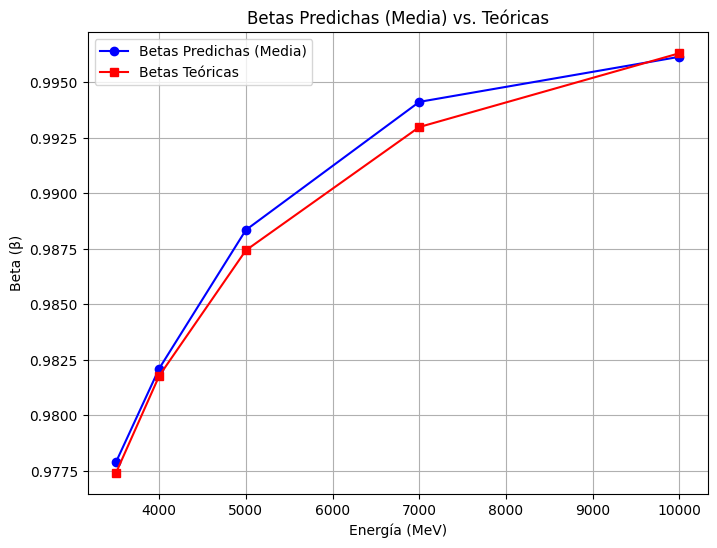

In [8]:
# Lista de energías correspondientes a los DataFrames
E = [3500, 4000, 5000, 7000, 10000]

# Listas vacías para guardar los resultados que vamos a graficar
mean_predicted_betas = []
betas_teo_list = []

print("\n\n📊 ===== Iniciando Análisis Individual por Energía =====")
# Iteramos sobre la lista de predicciones que creamos antes
for k, beta_preds in enumerate(all_predictions):
    if len(beta_preds) == 0:
        continue

    print(f"\n--- Análisis para Energía = {E[k]} MeV ---")

    beta_mean = beta_preds.mean()
    print(f"Media de β_pred: {beta_mean:.6f}")

    # Calculamos la beta teórica
    beta_teo = beta(E[k])

    # Guardamos la media de la predicción y el valor teórico en nuestras listas
    mean_predicted_betas.append(beta_mean)
    betas_teo_list.append(beta_teo)

plt.figure(figsize=(8, 6))

# Graficar las medias de las predicciones
plt.plot(E, mean_predicted_betas, marker='o', linestyle='-', color='blue', label='Betas Predichas (Media)')

# Graficar los valores teóricos
plt.plot(E, betas_teo_list, marker='s', linestyle='-', color='red', label='Betas Teóricas')

# Añadir título y etiquetas
plt.title('Betas Predichas (Media) vs. Teóricas')
plt.xlabel('Energía (MeV)')
plt.ylabel('Beta (β)')
plt.legend()
plt.grid(True)
plt.show()

Esta celda realiza una visualización agregada de los resultados, comparando la tendencia de las predicciones del modelo con la tendencia teórica.

1.  **Recopilación de Datos**: Se itera de nuevo sobre las predicciones para cada nivel de energía. En cada iteración:
    - Se calcula la **media** de las betas predichas.
    - Se calcula la **beta teórica** para esa energía.
    - Ambos valores se guardan en listas separadas (`mean_predicted_betas` y `betas_teo_list`).

2.  **Graficación Comparativa**: Se crea un único gráfico de líneas que muestra:
    - **Línea Azul**: La evolución de la **media de las betas predichas** a medida que aumenta la energía.
    - **Línea Roja**: La evolución de la **beta teórica** a medida que aumenta la energía.

Este gráfico es fundamental para evaluar si el modelo ha aprendido la relación física subyacente: ambas curvas deberían ser muy similares, mostrando que la velocidad ($\beta$) aumenta con la energía y se acerca asintóticamente a 1.

## Gráfica del ajuste lineal de betas predichas vs betas teóricas

Betas teoricas:  [0.9773985936997165, 0.9817840777767777, 0.9874384377528358, 0.9929902846976675, 0.9963142049869926]
Betas predichas:  [np.float32(0.97788405), np.float32(0.98211324), np.float32(0.9883546), np.float32(0.994123), np.float32(0.9961534)]
Pendiente de las betas predichas (m): 0.9950874387069475
Pendiente de las betas teóricas (m): 1.0000000000000127
Diferencia de pendientes: 0.004912561293065165


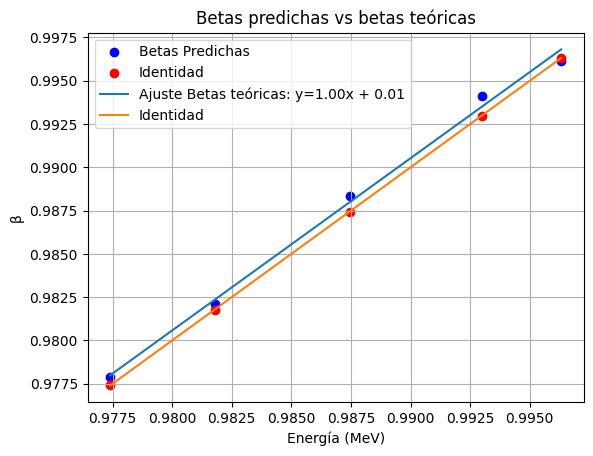



📊 ===== Iniciando Análisis Individual por Energía =====

--- Análisis para Energía = 3500 MeV ---
Análisis para E=3500 MeV: Beta Teórica=0.9774, Moda Predicha=0.9784

--- Análisis para Energía = 4000 MeV ---
Análisis para E=4000 MeV: Beta Teórica=0.9818, Moda Predicha=0.9827

--- Análisis para Energía = 5000 MeV ---
Análisis para E=5000 MeV: Beta Teórica=0.9874, Moda Predicha=0.9887

--- Análisis para Energía = 7000 MeV ---
Análisis para E=7000 MeV: Beta Teórica=0.9930, Moda Predicha=0.9947

--- Análisis para Energía = 10000 MeV ---
Análisis para E=10000 MeV: Beta Teórica=0.9963, Moda Predicha=0.9966


📈 ===== Generando Gráfica de Correlación Final con Modas =====


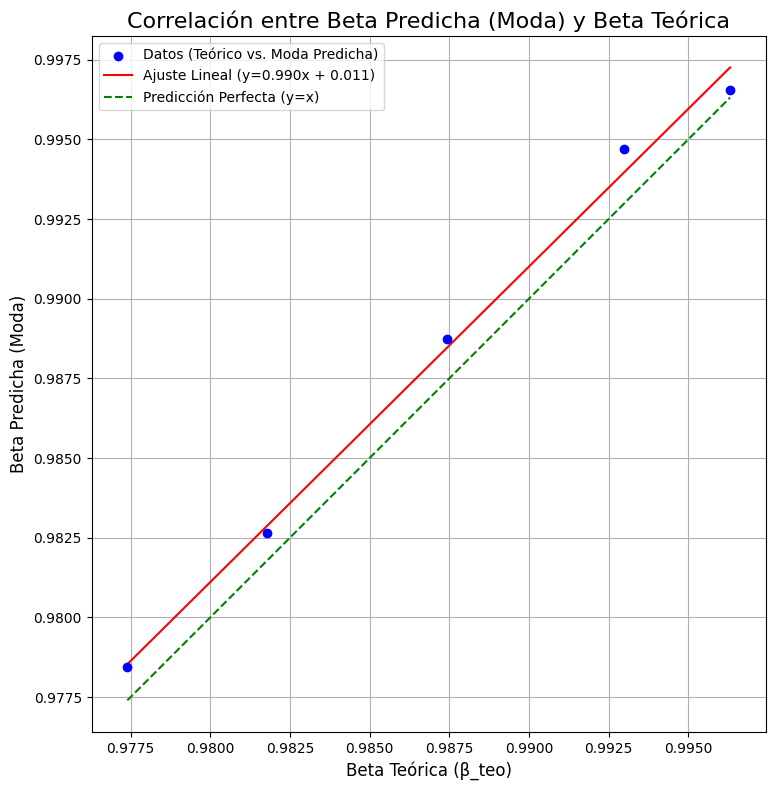

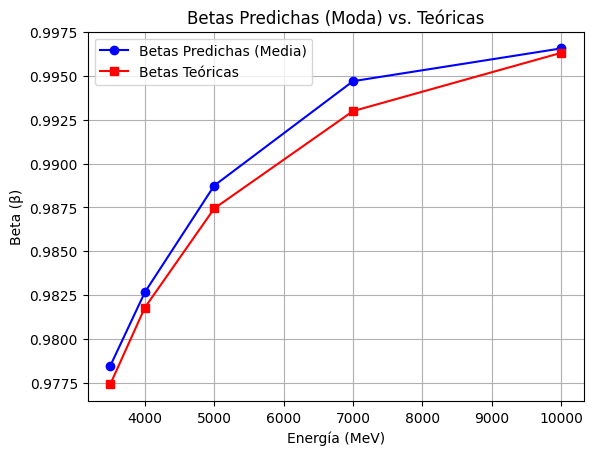

In [9]:
print("Betas teoricas: ", betas_teo_list)
print("Betas predichas: ", mean_predicted_betas)
betas_teo = np.array(betas_teo_list, dtype=float)
beta_promedios = np.array(mean_predicted_betas, dtype=float)

m1, b1 = np.polyfit(betas_teo, beta_promedios, 1)
m2, b2 = np.polyfit(betas_teo, betas_teo, 1)
print(f"Pendiente de las betas predichas (m): {m1}")
print(f"Pendiente de las betas teóricas (m): {m2}")
print(f'Diferencia de pendientes: {np.abs(m1-m2)}')

plt.scatter(betas_teo, beta_promedios, marker='o', color='blue', label='Betas Predichas')
plt.scatter(betas_teo, betas_teo, marker='o', color='red', label='Identidad')
plt.plot(betas_teo, m1*betas_teo + b1, label=f'Ajuste Betas teóricas: y={m1:.2f}x + {b1:.2f}')
plt.plot(betas_teo, m2*betas_teo + b2, label='Identidad')
plt.title('Betas predichas vs betas teóricas')
plt.xlabel('Energía (MeV)')
plt.ylabel('β')
plt.legend()
plt.grid(True)
plt.show()

#MODAS


mode_predicted_betas = [] # Lista para guardar los valores más probables
betas_teo_list = []      # Lista para guardar los valores teóricos

print("\n\n📊 ===== Iniciando Análisis Individual por Energía =====")
for k, beta_preds in enumerate(all_predictions):

    # Si este conjunto de predicciones está vacío, se salta.
    # Esto garantiza que ambas listas siempre tengan la misma longitud.
    if len(beta_preds) == 0:
        print(f"\n--- No hay datos para Energía con índice {k} (E={E[k]} MeV). Saltando. ---")
        continue

    print(f"\n--- Análisis para Energía = {E[k]} MeV ---")

    # Cálculo del valor más probable (Moda)
    kde = gaussian_kde(beta_preds)
    x_grid = np.linspace(beta_preds.min(), beta_preds.max(), 500)
    kde_values = kde(x_grid)
    beta_mode = x_grid[np.argmax(kde_values)]

    mode_predicted_betas.append(beta_mode)
    betas_teo_list.append(beta(E[k]))

    print(f"Análisis para E={E[k]} MeV: Beta Teórica={beta(E[k]):.4f}, Moda Predicha={beta_mode:.4f}")

print("\n\n📈 ===== Generando Gráfica de Correlación Final con Modas =====")

# Crear la gráfica de correlación con las modas
betas_teo = np.array(betas_teo_list)
beta_modas = np.array(mode_predicted_betas)

# Ajuste lineal
m, b = np.polyfit(betas_teo, beta_modas, 1)

# Crear la Gráfica
plt.figure(figsize=(8, 8))
plt.scatter(betas_teo, beta_modas, color='blue', label='Datos (Teórico vs. Moda Predicha)', zorder=5)
plt.plot(betas_teo, m * betas_teo + b, color='red', linestyle='-', label=f'Ajuste Lineal (y={m:.3f}x + {b:.3f})')
plt.plot(betas_teo, betas_teo, color='green', linestyle='--', label='Predicción Perfecta (y=x)')
plt.title('Correlación entre Beta Predicha (Moda) y Beta Teórica', fontsize=16)
plt.xlabel('Beta Teórica (β_teo)', fontsize=12)
plt.ylabel('Beta Predicha (Moda)', fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Graficar las medias de las predicciones
plt.plot(E, beta_modas, marker='o', linestyle='-', color='blue', label='Betas Predichas (Media)')

# Graficar los valores teóricos
plt.plot(E, betas_teo, marker='s', linestyle='-', color='red', label='Betas Teóricas')

# Añadir título y etiquetas
plt.title('Betas Predichas (Moda) vs. Teóricas')
plt.xlabel('Energía (MeV)')
plt.ylabel('Beta (β)')
plt.legend()
plt.grid(True)
plt.show()

Esta celda profundiza en el análisis de correlación entre los valores teóricos y los predichos.

1.  **Preparación de Datos**: Convierte las listas de betas teóricas y medias de betas predichas en arrays de NumPy para facilitar los cálculos numéricos.
2.  **Ajuste Lineal**: Utiliza `np.polyfit` para realizar dos ajustes lineales:
    - **Ajuste 1 (`m1`, `b1`)**: Ajusta una línea a los puntos ($\beta_{teo}$, $\beta_{pred}$), para ver la tendencia real de las predicciones.
    - **Ajuste 2 (`m2`, `b2`)**: Ajusta una línea a los puntos ($\beta_{teo}$, $\beta_{teo}$). Esto simplemente da la línea de identidad (y=x), con una pendiente `m2` que debería ser 1.
3.  **Análisis de Pendientes**: Imprime las pendientes de ambos ajustes y su diferencia. Una diferencia cercana a cero indica que la tendencia de las predicciones es muy similar a la ideal.
4.  **Graficación de Correlación**: Crea un gráfico de dispersión (`scatter plot`) que visualiza:
    - **Puntos Azules**: Los datos reales ($\beta_{teo}$ vs $\beta_{pred}$).
    - **Puntos Rojos**: La línea de identidad, que representa una predicción perfecta.
    - **Línea Sólida**: El ajuste lineal a las predicciones.
    - **Línea Discontinua**: La línea de identidad.

Un buen modelo mostrará los puntos azules muy cerca de la línea roja/discontinua, y la línea de ajuste sólida casi superpuesta a la de identidad.

Esta celda también realiza un análisis similar al anterior, pero en lugar de usar la **media**, utiliza la **moda** (el valor más probable) de las predicciones para evaluar el rendimiento. La moda puede ser una métrica más robusta si la distribución de las predicciones no es simétrica o tiene valores atípicos.

#### 1. **Cálculo de la Moda**
- Se itera sobre cada conjunto de predicciones de `all_predictions`.
- Se utiliza la técnica de **Estimación de Densidad Kernel (KDE)** de `scipy.stats` para crear una curva suave que estima la distribución de probabilidad de los datos.
- Se encuentra el **pico** de esta curva, que corresponde a la **moda** o el valor más probable de $\beta$ para esa energía.
- Estos valores de moda y los teóricos correspondientes se almacenan en las listas `mode_predicted_betas` y `betas_teo_list`.

#### 2. **Análisis de Correlación con la Moda**
- Se crea un gráfico de dispersión que compara la $\beta$ teórica con la **moda** de la $\beta$ predicha para cada energía.
- Al igual que antes, se superponen un **ajuste lineal** y la línea de **predicción perfecta (y=x)** para evaluar visualmente la alineación.

#### 3. **Gráfica Comparativa con la Moda**
- Finalmente, se genera un gráfico de líneas que compara:
    - La **moda de las betas predichas** (azul) en función de la energía.
    - La **beta teórica** (roja) en función de la energía.
- Esto complementa el análisis de la media, mostrando si el pico de la distribución de predicciones sigue la tendencia física esperada.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler


# Función para graficar
def graficar_anillo_beta_pred(puntos, beta_pred, n=1.03, D=420, centro=(0,0), color="green"):
    """
    Grafica el anillo de Cherenkov usando la beta predicha por el modelo.
    """
    if beta_pred * n <= 1:
        print(f"⚠️ No hay radiación de Cherenkov para la beta predicha (β*n = {beta_pred * n:.3f} <= 1)")
        return None

    # Ángulo Cherenkov
    theta_c = np.arccos(1.0 / (beta_pred * n))
    # Radio teórico
    R = D * np.tan(theta_c)

    # Graficar
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal")

    puntos = np.array(puntos)
    ax.scatter(puntos[:,0], puntos[:,1], color="blue", s=20, alpha=0.8, label="Hits del evento")

    circle_pred = plt.Circle(centro, R, fill=False, color=color, linewidth=2.5, linestyle='--',
                             label=f"Anillo Predicho (R={R:.2f} mm)")
    ax.add_patch(circle_pred)

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_title(f"Anillo de Cherenkov Predicho (β_pred = {beta_pred:.6f})")
    ax.legend()
    plt.grid(True)
    plt.show()

    return R

# Carga del modelo y el escalador
MODELO_PATH = "betanet_v5.h5"
SCALER_PATH = "data_scaler.pkl"
RUTA_CSV     = "/content/drive/MyDrive/datos hits/Prueba.csv"

if not os.path.exists(MODELO_PATH) or not os.path.exists(SCALER_PATH):
    print(f"❌ Error: No se encontraron los archivos '{MODELO_PATH}' o '{SCALER_PATH}'. Asegúrate de que estén en el directorio correcto.")
else:
    try:
        # Carga el modelo sin compilar para evitar el error de deserialización.
        model = tf.keras.models.load_model(MODELO_PATH, custom_objects={'r2_score': r2_score}, compile=False, safe_mode=False)

        # Vuelve a compilar el modelo con la misma configuración de entrenamiento.
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='mse',
            metrics=[r2_score]
        )

        with open(SCALER_PATH, 'rb') as f:
            scaler = pickle.load(f)
        print("✅ Modelo y escalador cargados y compilados correctamente.")

        # Regeneración de datos para seleccionar un ejemplo
        print("\n--- Recargando y procesando datos para el ejemplo ---")
        if os.path.exists(RUTA_CSV):
            df_full = pd.read_csv(RUTA_CSV)

            # Centrado y filtrado
            df_full[['x(mm)', 'y(mm)']] = df_full[['x(mm)', 'y(mm)']].apply(pd.to_numeric, errors='coerce')
            df_full[['x0(mm)', 'y0(mm)']] = df_full.groupby('eventID')[['x(mm)', 'y(mm)']].transform('mean')
            df_centered = df_full.copy()
            df_centered[['x(mm)', 'y(mm)']] = df_centered[['x(mm)', 'y(mm)']] - df_centered[['x0(mm)', 'y0(mm)']].to_numpy()
            radio_minimo = 20
            distancia = np.sqrt(df_centered["x(mm)"]**2 + df_centered["y(mm)"]**2)
            df_filtrado = df_centered[distancia >= radio_minimo].copy()

            # Extracción de características
            df_filtrado['radius'] = np.sqrt(df_filtrado['x(mm)']**2 + df_filtrado['y(mm)']**2)
            energy_col = next(c for c in df_filtrado.columns if "energy" in c.lower())
            features_list = []
            for event_id, grp in df_filtrado.groupby('eventID'):
                features_list.append({
                    'eventID': event_id,
                    'n_hits': len(grp),
                    'radius_mean': grp['radius'].mean(),
                    'radius_std': grp['radius'].std(),
                    'beta': beta(grp[energy_col].iloc[0])
                })
            df_features = pd.DataFrame(features_list).fillna(0)
            features = ['n_hits', 'radius_mean', 'radius_std']
            print("✅ Datos procesados.")

            # Selecciona un evento
            evento_ejemplo = df_features.sample(3).iloc[0]
            evento_id_ejemplo = int(evento_ejemplo['eventID'])
            beta_teorica_ejemplo = evento_ejemplo['beta']

            print(f"\n--- Evento de Ejemplo Seleccionado: ID = {evento_id_ejemplo} ---")
            print(f"Beta Teórica (real) para este evento: {beta_teorica_ejemplo:.6f}")

            # Preparar datos para predicción
            features_ejemplo = evento_ejemplo[features].values.reshape(1, -1)
            features_ejemplo_scaled = scaler.transform(features_ejemplo)

            # Predecir Beta
            beta_predicha_ejemplo = model.predict(features_ejemplo_scaled, verbose=0)[0, 0]
            print(f"Beta Predicha por el modelo: {beta_predicha_ejemplo:.6f}")

            # Obtener los puntos (hits)
            puntos_evento_ejemplo = df_filtrado[df_filtrado['eventID'] == evento_id_ejemplo][['x(mm)', 'y(mm)']].values
            print(puntos_evento_ejemplo)

            # Graficar el anillo
            if puntos_evento_ejemplo.shape[0] > 0:
                print("\nGenerando la gráfica del anillo de Cherenkov...")
                radio_predicho = graficar_anillo_beta_pred(
                    puntos=puntos_evento_ejemplo,
                    beta_pred=beta_predicha_ejemplo
                )
                if radio_predicho is not None:
                    print(f"Radio del anillo predicho: {radio_predicho:.2f} mm")
            else:
                print(f"No se encontraron hits para el evento {evento_id_ejemplo} en el dataframe filtrado.")
        else:
            print(f"❌ Error: No se encontró el archivo de datos '{RUTA_CSV}'.")
    except Exception as e:
        print(f"❌ Ocurrió un error: {e}")

Esta celda final realiza una demostración completa de "extremo a extremo": desde la carga de datos hasta la visualización de una predicción para un único evento aleatorio, uniendo todos los componentes anteriores.

#### 1. **Definiciones y Carga de Activos**
- Se define la función `graficar_anillo_beta_pred`, que toma los puntos de un *hit* y un valor de $\beta$ predicho para calcular y dibujar el anillo de Cherenkov correspondiente.
- Se cargan el modelo (`betanet_v5.h5`) y el escalador (`data_scaler.pkl`) previamente guardados, incluyendo la recompilación del modelo para que esté listo para la predicción.

#### 2. **Regeneración de Datos**
- Se vuelve a cargar y procesar el archivo `Prueba.csv`. Esto incluye el centrado, filtrado radial y la ingeniería de características para tener un DataFrame (`df_features`) donde cada fila representa un evento con sus características numéricas.

#### 3. **Predicción para un Evento de Ejemplo**
- **Selección**: Se elige un evento al azar del DataFrame `df_features`.
- **Preparación**: Las características de este único evento se extraen, se ajustan en su forma y se escalan con el `scaler` cargado.
- **Predicción**: Se usa `model.predict()` para obtener una única predicción de $\beta$.
- **Obtención de *Hits***: Se buscan en el DataFrame `df_filtrado` todos los *hits* que corresponden al ID del evento seleccionado.

#### 4. **Visualización Final**
- Se llama a la función `graficar_anillo_beta_pred`.
- Esto genera un gráfico de dispersión de los *hits* (azul) y superpone el anillo de Cherenkov calculado a partir de la predicción del modelo (círculo verde).
- El resultado es una validación visual que conecta la predicción numérica del modelo con su interpretación física y geométrica.